In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', 200)
import geopandas as gpd
from math import isnan
from state_data import load_state_data
import matplotlib.pyplot as plt; plt.style.use('ggplot')

In [2]:
min_total_enrollment = 100
endowment_cutoff = 25000

Desired outputs (for all schools with enrollment ≥100):
* Total undergraduate and graduate enrollment (from IPEDS data)
* Total dorm capacity
  - Figure out what universities are undergrad-only; keep these dorm capacities
  - For graduate schools, separate out
* Carnegie classifications (probably useful, as they're pre-established)
  - Plot: schools on two axes (endowment per capita scaled somehow and % in dorms) 
* How to handle community colleges and professional schools?
  - Probably just exclude professional schools entirely
  - Produce a version with and w/o two-year schools (endowment math is different)

In [3]:
dhs_gdf = gpd.read_file('data/Colleges_and_Universities/Colleges_and_Universities.shp')
dhs_gdf = dhs_gdf[dhs_gdf['STATE'] == 'MA']

In [4]:
ipeds_df = pd.read_csv('data/IPEDS/MA_colleges_enrollment_endowment.csv')

In [5]:
ipeds_columns = {
    'institution name': 'name',
    'HD2018.Carnegie Classification 2018: Basic': 'carnegie_classification',
    'HD2018.Carnegie Classification 2018: Size and Setting': 'carnegie_size_and_setting',
    'HD2018.Institutional category': 'institutional_category',
    'DRVEF2018.Total  enrollment': 'total_enrollment',
    'DRVEF2018.Undergraduate enrollment': 'undergrad_enrollment',
    'DRVEF2018.Graduate enrollment': 'grad_enrollment',
    'DRVF2018.Endowment assets (year end) per FTE enrollment (GASB)': 'endowment_per_fte_gasb',
    'DRVF2018.Endowment assets (year end) per FTE enrollment (FASB)': 'endowment_per_fte_fasb',
}

In [6]:
ipeds_df = ipeds_df.rename(columns=ipeds_columns)
ipeds_df = ipeds_df[list(ipeds_columns.values())]
ipeds_df = ipeds_df[ipeds_df['total_enrollment'] >= min_total_enrollment]

In [7]:
size_and_setting = ipeds_df['carnegie_size_and_setting'].str.split(', ', expand=True)
ipeds_df['carnegie_years'] = size_and_setting[0]
ipeds_df['carnegie_size'] = size_and_setting[1]
ipeds_df['carnegie_setting'] = size_and_setting[2].fillna('primarily nonresidential')
ipeds_df = ipeds_df[ipeds_df['carnegie_years'].isin(['Two-year', 'Four-year'])]
ipeds_df = ipeds_df[ipeds_df['name'] != 'Northeastern University Lifelong Learning Network']
ipeds_df = ipeds_df.reset_index(drop=True)

In [8]:
def endowment_merge(row):
    if not isnan(row['endowment_per_fte_gasb']):
        return row['endowment_per_fte_gasb']
    if not isnan(row['endowment_per_fte_fasb']):
        return row['endowment_per_fte_fasb']
    return 0

ipeds_df['endowment_per_fte'] = ipeds_df.apply(endowment_merge, axis=1)
ipeds_df = ipeds_df.drop(columns=['endowment_per_fte_gasb',
                                  'endowment_per_fte_fasb'])

In [9]:
dhs_gdf['NAME'] = dhs_gdf['NAME'].str.replace('SIMMONS COLLEGE', 'SIMMONS UNIVERSITY')
dhs_gdf['DORM_CAP'] = dhs_gdf['DORM_CAP'].replace(-999, 0)
dhs_columns = {
    'NAME': 'name_caps',
    'POPULATION': 'dhs_population',
    'TOT_ENROLL': 'dhs_enrollment',
    'DORM_CAP': 'dorm_capacity'
}
dhs_gdf = dhs_gdf.rename(columns=dhs_columns)
dhs_gdf = dhs_gdf[list(dhs_columns.values()) + ['geometry']].reset_index(drop=True)
dhs_gdf = dhs_gdf[dhs_gdf['name_caps'].isin(ipeds_df['name'].str.upper())]

In [10]:
ipeds_df['name_caps'] = ipeds_df['name'].str.upper()
colleges_gdf = ipeds_df.set_index('name_caps').join(dhs_gdf.set_index('name_caps')).reset_index(drop=True)

In [11]:
colleges_gdf = colleges_gdf[colleges_gdf['carnegie_years'] == 'Four-year']
colleges_gdf = gpd.GeoDataFrame(colleges_gdf)
colleges_gdf.crs = dhs_gdf.crs

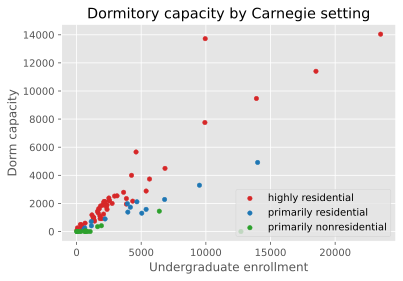

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
settings = ['highly residential', 'primarily residential', 'primarily nonresidential']
colors = ['tab:red', 'tab:blue', 'tab:green']
for color, setting in zip(colors, settings):
    setting_df = pd.DataFrame(colleges_gdf[colleges_gdf['carnegie_setting'] == setting])
    setting_df.plot.scatter(x='undergrad_enrollment',
                            y='dorm_capacity',
                            ax=ax,
                            color=color,
                            label=setting)
plt.legend(loc='lower right')
plt.xlabel('Undergraduate enrollment')
plt.ylabel('Dorm capacity')
plt.title('Dormitory capacity by Carnegie setting')
plt.savefig('dorm_capacity_by_carnegie_setting.png', dpi=300, bbox_inches='tight')
plt.show()

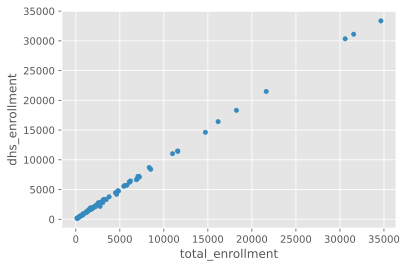

In [20]:
pd.DataFrame(colleges_gdf).plot.scatter(x='total_enrollment', y='dhs_enrollment')
plt.show()

In [21]:
colleges_gdf[(colleges_gdf['grad_enrollment'] > 0) &
             (colleges_gdf['dorm_capacity'] > 0)].sort_values(by='total_enrollment',
                                                              ascending=False)

,name,carnegie_classification,carnegie_size_and_setting,institutional_category,total_enrollment,undergrad_enrollment,grad_enrollment,carnegie_years,carnegie_size,carnegie_setting,endowment_per_fte,dhs_population,dhs_enrollment,dorm_capacity,geometry
15,Boston University,Doctoral Universities: Very High Research Acti...,"Four-year, large, highly residential","Degree-granting, primarily baccalaureate or above",34657.0,18515.0,16142.0,Four-year,large,highly residential,66757.0,43537,33355,11403,POINT (-71.09984 42.34958)
37,Harvard University,Doctoral Universities: Very High Research Acti...,"Four-year, large, highly residential","Degree-granting, primarily baccalaureate or above",31566.0,9950.0,21616.0,Four-year,large,highly residential,1422130.0,49916,31120,13723,POINT (-71.11823 42.37417)
47,University of Massachusetts-Amherst,Doctoral Universities: Very High Research Acti...,"Four-year, large, highly residential","Degree-granting, primarily baccalaureate or above",30593.0,23515.0,7078.0,Four-year,large,highly residential,11333.0,36316,30340,14044,POINT (-72.52931 42.38865)
67,Northeastern University,Doctoral Universities: Very High Research Acti...,"Four-year, large, highly residential","Degree-granting, primarily baccalaureate or above",21627.0,13909.0,7718.0,Four-year,large,highly residential,34253.0,25835,21489,9466,POINT (-71.08807 42.34018)
46,University of Massachusetts-Lowell,Doctoral Universities: High Research Activity,"Four-year, large, primarily residential","Degree-granting, primarily baccalaureate or above",18242.0,14004.0,4238.0,Four-year,large,primarily residential,6254.0,20537,18315,4916,POINT (-71.32508 42.65372)
14,Boston College,Doctoral Universities: Very High Research Acti...,"Four-year, large, highly residential","Degree-granting, primarily baccalaureate or above",14720.0,9927.0,4793.0,Four-year,large,highly residential,192521.0,18934,14628,7757,POINT (-71.16924 42.33620)
85,Tufts University,Doctoral Universities: Very High Research Acti...,"Four-year, large, highly residential","Degree-granting, primarily baccalaureate or above",11586.0,5643.0,5943.0,Four-year,large,highly residential,157828.0,16429,11449,3735,POINT (-71.12064 42.40600)
52,Massachusetts Institute of Technology,Doctoral Universities: Very High Research Acti...,"Four-year, large, highly residential","Degree-granting, primarily baccalaureate or above",11574.0,4602.0,6972.0,Four-year,large,highly residential,1454419.0,25171,11466,5660,POINT (-71.09211 42.36010)
17,Bridgewater State University,Master's Colleges & Universities: Larger Programs,"Four-year, medium, primarily residential","Degree-granting, primarily baccalaureate or above",10990.0,9504.0,1486.0,Four-year,medium,primarily residential,5372.0,12552,11019,3295,POINT (-70.96429 41.98651)
82,University of Massachusetts-Dartmouth,Doctoral Universities: High Research Activity,"Four-year, medium, highly residential","Degree-granting, primarily baccalaureate or above",8513.0,6841.0,1672.0,Four-year,medium,highly residential,7372.0,9792,8406,4494,POINT (-71.00684 41.62900)


In [22]:
colleges_gdf[colleges_gdf['name'] == 'Harvard University']

,name,carnegie_classification,carnegie_size_and_setting,institutional_category,total_enrollment,undergrad_enrollment,grad_enrollment,carnegie_years,carnegie_size,carnegie_setting,endowment_per_fte,dhs_population,dhs_enrollment,dorm_capacity,geometry
37,Harvard University,Doctoral Universities: Very High Research Acti...,"Four-year, large, highly residential","Degree-granting, primarily baccalaureate or above",31566.0,9950.0,21616.0,Four-year,large,highly residential,1422130.0,49916,31120,13723,POINT (-71.11823 42.37417)


In [23]:
colleges_gdf.columns

Index(['name', 'carnegie_classification', 'carnegie_size_and_setting',
       'institutional_category', 'total_enrollment', 'undergrad_enrollment',
       'grad_enrollment', 'carnegie_years', 'carnegie_size',
       'carnegie_setting', 'endowment_per_fte', 'dhs_population',
       'dhs_enrollment', 'dorm_capacity', 'geometry'],
      dtype='object')

In [29]:
def quadrant(row):
    if row['endowment_per_fte'] >= endowment_cutoff and row['carnegie_setting'] == 'highly residential':
        return 'More resourced, more residential'
    elif row['endowment_per_fte'] >= endowment_cutoff and row['carnegie_setting'] != 'highly residential':
        return 'More resourced, less residential'
    elif row['endowment_per_fte'] < endowment_cutoff and row['carnegie_setting'] == 'highly residential':
        return 'Less resourced, more residential'
    return 'Less resourced, less residential'

colleges_gdf['quadrant'] = colleges_gdf.apply(quadrant, axis=1)
colleges_gdf['broad'] = colleges_gdf['quadrant'].apply(lambda x: True if x == 'More resourced, more residential' else False)

In [ ]:
colleges_gdf.to_excel('ma_college_classification_v1_full.xlsx')

In [30]:
colleges_gdf[['name', 'quadrant', 'broad', 'carnegie_size_and_setting', 'total_enrollment', 'undergrad_enrollment', 'grad_enrollment', 'endowment_per_fte', 'dorm_capacity']]#.to_excel('ma_college_classification_v1.xlsx')

,name,quadrant,broad,carnegie_size_and_setting,total_enrollment,undergrad_enrollment,grad_enrollment,endowment_per_fte,dorm_capacity
0,Hult International Business School,"Less resourced, less residential",False,"Four-year, small, primarily residential",3065.0,574.0,2491.0,0.0,155
1,New England College of Business and Finance,"Less resourced, less residential",False,"Four-year, very small, primarily nonresidential",1237.0,1053.0,184.0,0.0,0
2,American International College,"Less resourced, more residential",False,"Four-year, small, highly residential",3152.0,1336.0,1816.0,7656.0,853
3,Amherst College,"More resourced, more residential",True,"Four-year, small, highly residential",1855.0,1855.0,0.0,1223642.0,1820
4,Anna Maria College,"Less resourced, less residential",False,"Four-year, small, primarily residential",1461.0,1134.0,327.0,4301.0,711
5,Assumption College,"More resourced, more residential",True,"Four-year, small, highly residential",2428.0,2036.0,392.0,43690.0,1879
6,Babson College,"More resourced, more residential",True,"Four-year, small, highly residential",3357.0,2361.0,996.0,113786.0,1894
7,Bay Path University,"Less resourced, less residential",False,"Four-year, small, primarily nonresidential",3444.0,1923.0,1521.0,16390.0,411
8,Bay State College,"Less resourced, less residential",False,"Four-year, very small, primarily nonresidential",700.0,700.0,0.0,0.0,65
9,Becker College,"Less resourced, more residential",False,"Four-year, small, highly residential",1839.0,1824.0,15.0,2764.0,916


In [31]:
colleges_gdf.to_file('data/MA_Universities/ma_4_year_ipeds.geojson', driver='GeoJSON')

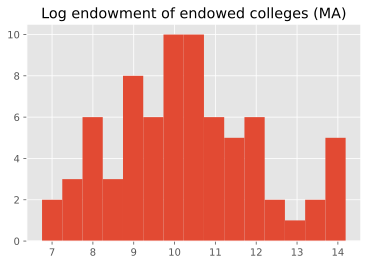

In [28]:
endowed_gdf = colleges_gdf[colleges_gdf['endowment_per_fte'] > 0]
plt.hist(np.log(endowed_gdf['endowment_per_fte'].to_numpy()), bins=15)
plt.title('Log endowment of endowed colleges (MA)')
plt.show()

In [ ]:
endowed_gdf = colleges_gdf[colleges_gdf['endowment_per_fte'] > 0]
plt.hist(endowed_gdf['endowment_per_fte'].to_numpy(), bins=30)
plt.title('Endowment of endowed colleges (MA)')
plt.show()

In [ ]:
colleges_gdf['endowment_per_fte'].quantile(.52)

In [ ]:
colleges_gdf['quadrant'].value_counts()

## TODO
- Undergrad populations/undergrad housing numbers for schools with lots of grad students
- Quadrants: {highly residential/less residential} // {low endowment per capita/high endowment per capita}

In [ ]:
# Trying to make sense of the HOUSING column (1 = residential?)
dhs_gdf.columns

In [ ]:
us_colleges_df[['COLLEGE', 'CAMPUS', 'CITY', 'NCES_TYPE', 'CATEGORY', 'DEGREEOFFR',
             'AWARDSOFFR', 'CAMPUSHOUS', 'ENROLL', 'DORM_CAP', 'ENDOW']]